In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import geopandas as gpd
import lxml
import missingno as msno
import numpy as np
import pandas as pd
from shapely.geometry import Point

from urbana.constants import DIR_REPO, DIR_DATA

In [4]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

YEAR = 2017
MONTH = 7

SAVE_INTERIM = True
OUTPUT_WARNINGS = False

In [5]:
if not OUTPUT_WARNINGS:
    import warnings

    warnings.filterwarnings("ignore")

# Open Data



## City maps

We will take a list of the neighbourhoods and districts with information to plot them from:

https://opendata-ajuntament.barcelona.cat/data/en/dataset/20170706-districtes-barris

In [6]:
geo_info = gpd.read_file(
    DIR_DATA / "raw/0301100100_UNITATS_ADM_POLIGONS.json"
)

# Neighbourhoods
neigh = geo_info[geo_info["SCONJ_DESC"] == "Barri"]
neigh = neigh[["DISTRICTE", "BARRI", "geometry"]]
neigh.rename(
    {"BARRI": "N_neighbourhood", "DISTRICTE": "N_district"},
    axis=1,
    inplace=True,
)

# Change the coordinates to latitude and longitude
neigh["geometry"] = neigh["geometry"].to_crs("EPSG:4326")

neigh["Tag"] = neigh["N_district"] + "_" + neigh["N_neighbourhood"]
neigh.sort_values(by=["Tag"], inplace=True)
neigh.set_index("Tag", inplace=True)

## Distance to city center

We assume the city center to be "Plaza Catalunya" (2.1700471, 41.3870154) and we will compute the distance of the centroid of each section to it.

To do so, we apply the *Haversine distance* between "Plaza Catalunya" and each centroid. Units chosen are km.

In [7]:
plaza_catalunya = Point(2.1700471, 41.3870154)
lon1 = np.radians(neigh["geometry"].centroid.x)
lon2 = np.radians(plaza_catalunya.x)

lat2 = np.radians(plaza_catalunya.y)
lat1 = np.radians(neigh["geometry"].centroid.y)
dlon = lon2 - lon1
dlat = lat2 - lat1
a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
c = 2 * np.arcsin(np.sqrt(a))
R_earth = 6371
d_haversine = c * R_earth
d_haversine = d_haversine.to_frame("Distance_Center")

neigh = pd.merge(
    left=neigh,
    right=d_haversine,
    how="left",
    left_index=True,
    right_index=True,
)

# POI

https://opendata-ajuntament.barcelona.cat/data/en/dataset/cens-activitats-comercials

In [8]:
econ = pd.read_csv(DIR_DATA / "raw/2019_censcomercialbcn_detall.csv")

econ = econ[
    [
        "Codi_Sector_Activitat",
        "Codi_Grup_Activitat",
        "Codi_Activitat_2019",
        "Nom_Grup_Activitat",
        "Codi_Districte",
        "Codi_Barri",
    ]
]
econ.rename(
    {
        "Codi_Sector_Activitat": "Code_sector",
        "Codi_Grup_Activitat": "Code_group",
        "Nom_Grup_Activitat": "Name_Group",
        "Codi_Activitat_2019": "Code_activity",
        "Codi_Districte": "N_district",
        "Codi_Barri": "N_neighbourhood",
    },
    axis=1,
    inplace=True,
)

# Remove incorrect information
econ = econ[econ["Code_group"] != 0]
econ.dropna(subset=["N_neighbourhood"], axis=0, inplace=True)

econ["Tag"] = (
    econ["N_district"].map("{:02d}".format)
    + "_"
    + econ["N_neighbourhood"].map("{:02d}".format)
)


# Group by codes and count
econ = (
    econ.groupby(["Tag", "Code_sector", "Code_group", "Code_activity", "Name_Group"])
    .size()
    .to_frame("Count")
    .reset_index()
)

In [9]:
def sum_Points(acts):
    result = pd.DataFrame(index=neigh.index)
    empty = pd.DataFrame(index=neigh.index)
    for i in acts:
        empty[str(i)] = econ[econ["Code_activity"] == i].set_index("Tag")["Count"]
    empty.fillna(0, inplace=True)
    result["myResult"] = empty.sum(axis=1)
    return result["myResult"]

In [10]:
econ_list = pd.DataFrame(index=neigh.index)
econ_group = (
    econ.groupby(["Tag", "Name_Group"])["Count"]
    .agg("sum")
    .to_frame("Count")
    .reset_index()
)

# LIST OF CATEGORIES DEFINED
econ_list["POI_Daily_Food"] = (
    econ_group[econ_group["Name_Group"] == "Quotidià alimentari"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Daily_Others"] = (
    econ_group[econ_group["Name_Group"] == "Quotidià no alimentari"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_House_Equipment"] = (
    econ_group[econ_group["Name_Group"] == "Parament de la llar"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Clothing"] = (
    econ_group[econ_group["Name_Group"] == "Equipament personal"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Culture"] = (
    econ_group[econ_group["Name_Group"] == "Oci i cultura"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Vehicles"] = (
    econ_group[econ_group["Name_Group"] == "Automoció"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_State_Agents"] = (
    econ_group[econ_group["Name_Group"] == "Activitats immobiliàries"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Education"] = (
    econ_group[econ_group["Name_Group"] == "Ensenyament"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Finances"] = (
    econ_group[econ_group["Name_Group"] == "Finances i assegurances"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Restaurants_Hotels"] = (
    econ_group[
        econ_group["Name_Group"]
        == "Restaurants, bars i hotels (Inclòs hostals, pensions i fondes)"
    ]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Health"] = (
    econ_group[econ_group["Name_Group"] == "Sanitat i assistència"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)

econ_list["POI_Souvenirs_Thrift_Store"] = sum_Points([7004000, 7004010, 7004020])
econ_list["POI_Car_Parks"] = sum_Points([1600000])
econ_list["POI_Esthetics"] = sum_Points([1600600, 1600700, 1600800])
econ_list["POI_Sports"] = sum_Points([1700300, 1700310, 1700320])
econ_list["POI_Religion"] = sum_Points([1700400])
econ_list["POI_Administration"] = sum_Points([1700100])


econ_list.fillna(0, inplace=True)
econ_list = econ_list.astype("int")

# Merge the data
neigh = pd.merge(
    left=neigh,
    right=econ_list,
    how="left",
    left_index=True,
    right_index=True,
)

# Inside Airbnb

We can extract information about the Airbnbs in Barcelona from:

http://insideairbnb.com/get-the-data.html

Instead of dowloading the files by clicking them one by one, we can exploit the fact that they all have the same url structure to download them straight from pandas. This is useful in the case in ehich we would like to download them all.

'http://data.insideairbnb.com/spain/catalonia/barcelona/' + *Date in "%Y-%m-%d" format* + '/data/listings.csv.gz'

## Available data

In [11]:
# Dates in which the files were uploaded (so far)
airbnb_dates = [
    "2015-04-30",
    "2015-07-17",
    "2015-09-04",
    "2015-10-02",
    "2016-01-03",
    "2016-11-07",
    "2016-12-08",
    "2017-01-04",
    "2017-02-09",
    "2017-03-06",
    "2017-04-08",
    "2017-05-07",
    "2017-06-05",
    "2017-07-06",
    "2017-08-06",
    "2017-09-12",
    "2017-10-07",
    "2017-11-13",
    "2017-12-09",
    "2018-01-17",
    "2018-02-07",
    "2018-04-12",
    "2018-05-14",
    "2018-06-09",
    "2018-07-10",
    "2018-08-14",
    "2018-09-11",
    "2018-10-10",
    "2018-11-07",
    "2018-12-10",
    "2019-01-14",
    "2019-02-06",
    "2019-03-08",
    "2019-04-10",
    "2019-05-14",
    "2019-06-07",
    "2019-07-10",
    "2019-08-12",
    "2019-09-17",
    "2019-10-16",
    "2019-11-09",
    "2019-12-10",
    "2020-01-10",
    "2020-02-16",
    "2020-03-16",
    "2020-04-16",
    "2020-05-11",
    "2020-06-13",
    "2020-07-17",
    "2020-08-24",
    "2020-09-12",
    "2020-10-12",
    "2020-11-06",
    "2020-12-16",
    "2021-01-12",
    "2021-02-09",
]

# Choose the data to download
airbnb_chosen = [
    i for i in airbnb_dates if i.startswith(str(YEAR) + "-" + "{:02d}".format(MONTH))
]
airbnb_chosen = pd.to_datetime(airbnb_chosen[0], format="%Y-%m-%d", errors="ignore")

In [12]:
airbnb_number_neigh = neigh[["N_district", "N_neighbourhood"]]
airbnb_price_neigh = neigh[["N_district", "N_neighbourhood"]]
airbnb_price_person_neigh = neigh[["N_district", "N_neighbourhood"]]
airbnb_loc_review_neigh = neigh[["N_district", "N_neighbourhood"]]

###########################################################
airbnb_url = (
    "http://data.insideairbnb.com/spain/catalonia/barcelona/"
    + airbnb_chosen.strftime("%Y-%m-%d")
    + "/data/listings.csv.gz"
)
df = pd.read_csv(airbnb_url)

print("File opened succesfully!")

date = airbnb_chosen.strftime("%Y_%m")

# Some rows are wrong
df = df[df["price"].str.contains("-") == False]

# Make the prices numbers and remove outliers (prices over 1000)
df["price"] = df["price"].str.replace("$", "").str.replace(",", "").astype("float")
df = df[df["price"] < 1000]
df["price_person"] = df["price"].div(df["accommodates"])
df["review_scores_location"] = df["review_scores_location"].astype("float")

df = df[["price", "price_person", "review_scores_location", "latitude", "longitude"]]

df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

df.drop(["longitude", "latitude"], axis=1, inplace=True)

# Set the column for the tags
df["Tag"] = -1

# Classify the Airbnbs based on their location
for i in range(len(neigh.index)):
    selection = df["geometry"].within(neigh["geometry"][i])
    selection_index = selection[selection].index
    df.loc[selection_index, "Tag"] = neigh.index[i]

# Remove points that couldn't be classified
df = df[df["Tag"] != -1]

print("Positions processed succesfully!")


########################################################################################################################3
# # Extract the data from the file

temp_number_neigh = (
    df["Tag"].value_counts().rename("Airbnb_Number").sort_index().to_frame()
)

temp_price_neigh = (
    df.groupby(["Tag"])["price"].agg("mean").rename("Airbnb_Price").sort_index()
).to_frame()

temp_price_person_neigh = (
    df.groupby(["Tag"])["price_person"]
    .agg("mean")
    .rename("Airbnb_Price_Person")
    .sort_index()
).to_frame()

temp_loc_review_neigh = (
    df.groupby(["Tag"])["review_scores_location"]
    .agg("mean")
    .rename("Airbnb_Location_Score")
    .sort_index()
).to_frame()

neigh = pd.merge(
    left=neigh,
    right=temp_number_neigh,
    how="left",
    left_index=True,
    right_index=True,
)

neigh = pd.merge(
    left=neigh,
    right=temp_price_neigh,
    how="left",
    left_index=True,
    right_index=True,
)

neigh = pd.merge(
    left=neigh,
    right=temp_price_person_neigh,
    how="left",
    left_index=True,
    right_index=True,
)


neigh = pd.merge(
    left=neigh,
    right=temp_loc_review_neigh,
    how="left",
    left_index=True,
    right_index=True,
)

neigh.fillna({"Airbnb_Number": 0}, inplace=True)
neigh["Airbnb_Number"] = neigh["Airbnb_Number"].astype("int")

File opened succesfully!
Positions processed succesfully!


# Barcelona City Council

## Gender

http://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a2017/sexe/sexe03.htm

In [13]:
table_gender = pd.read_html(
    "https://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a"
    + str(YEAR)
    + "/sexe/sexe03.htm",
    thousands=".",
)

gender = table_gender[0]
gender.columns = gender.loc[4]
gender.drop(labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 82, 83, 84, 85], axis=0, inplace=True)
gender = gender.loc[:, ~gender.columns.duplicated()]
gender[["N_district", "N_neighbourhood"]] = gender["Dto. Barrios"].str.split(
    " ", 1, expand=True
)

gender["N_neighbourhood"] = gender["N_neighbourhood"].str.split(".").str[0]

gender["N_district"] = gender["N_district"].astype("int")
gender["N_neighbourhood"] = gender["N_neighbourhood"].astype("int")

gender["Tag"] = (
    gender["N_district"].map("{:02d}".format)
    + "_"
    + gender["N_neighbourhood"].map("{:02d}".format)
)
gender.columns.name = None

gender.set_index("Tag", inplace=True)

gender["Mujeres"] = gender["Mujeres"].astype("int").div(gender["TOTAL"].astype("int"))

gender.drop(
    ["Dto. Barrios", "N_district", "N_neighbourhood", "Hombres", "TOTAL"],
    axis=1,
    inplace=True,
)

gender.rename({"Mujeres": "Percentage_Gender_Female"}, axis=1, inplace=True)

neigh = pd.merge(
    left=neigh,
    right=gender,
    how="left",
    left_index=True,
    right_index=True,
)

## Age

http://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a2017/edat/edatg05.htm

In [14]:
table_age = pd.read_html(
    "https://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a"
    + str(YEAR)
    + "/edat/edatg05.htm",
    thousands=".",
)

age = table_age[0]
age.columns = age.loc[4]
age.drop(labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 82, 83, 84, 85], axis=0, inplace=True)
age = age.loc[:, ~age.columns.duplicated()]

age[["N_district", "N_neighbourhood"]] = age["Dto. Barrios"].str.split(
    " ", 1, expand=True
)

age["N_neighbourhood"] = age["N_neighbourhood"].str.split(".").str[0]

age["N_district"] = age["N_district"].astype("int")
age["N_neighbourhood"] = age["N_neighbourhood"].astype("int")

age["Tag"] = (
    age["N_district"].map("{:02d}".format)
    + "_"
    + age["N_neighbourhood"].map("{:02d}".format)
)
age.columns.name = None

age.set_index("Tag", inplace=True)

age.rename(
    {
        "0-14 años": "Percentage_Age_0_14",
        "15-24 años": "Percentage_Age_15_24",
        "25-39 años": "Percentage_Age_25_39",
        "40-64 años": "Percentage_Age_40_64",
        "65 años y más": "Percentage_Age_65_Plus",
    },
    axis=1,
    inplace=True,
)

age.drop(["Dto. Barrios", "N_district", "N_neighbourhood"], axis=1, inplace=True)

for col in reversed(age.columns):
    age[col] = age[col].astype("int").div(age["TOTAL"].astype("int"))

age.drop(["TOTAL"], axis=1, inplace=True)

neigh = pd.merge(
    left=neigh,
    right=age,
    how="left",
    left_index=True,
    right_index=True,
)

## Mean household

http://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a2017/llars/ocu02.htm

In [15]:
table_household = pd.read_html(
    "https://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a"
    + str(YEAR)
    + "/llars/ocu02.htm",
    thousands=".",
    decimal=",",
)

household = table_household[0]
household.columns = household.loc[4]
household.drop(labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 82, 83, 84, 85], axis=0, inplace=True)
household = household.loc[:, ~household.columns.duplicated()]
household[["N_district", "N_neighbourhood"]] = household["Dto. Barrios"].str.split(
    " ", 1, expand=True
)

household["N_neighbourhood"] = household["N_neighbourhood"].str.split(".").str[0]

household["N_district"] = household["N_district"].astype("int")
household["N_neighbourhood"] = household["N_neighbourhood"].astype("int")

household["Tag"] = (
    household["N_district"].map("{:02d}".format)
    + "_"
    + household["N_neighbourhood"].map("{:02d}".format)
)
household.columns.name = None

household.set_index("Tag", inplace=True)

household.drop(
    ["Dto. Barrios", "N_district", "N_neighbourhood", "Población", "Domicilios"],
    axis=1,
    inplace=True,
)

household.rename(
    {"Ocupación media (personas por domicilio)": "Household"}, axis=1, inplace=True
)

household["Household"] = household["Household"].astype("float")

neigh = pd.merge(
    left=neigh,
    right=household,
    how="left",
    left_index=True,
    right_index=True,
)

## Education Level

Given the Spanish education system, the groups are defined as:


*   Elementary School = Primaria (6-12 years)
*   Middle School = Secundaria (13-16 years)
*   High School = Bachillerato (17-18 years)

The data is extracted from:


http://www.bcn.cat/estadistica/angles/dades/tpob/pad/padro/a2017/nivi/nivi05.htm

In [16]:
table_education = pd.read_html(
    "https://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a"
    + str(YEAR)
    + "/nivi/nivi05.htm",
    thousands=".",
)

education = table_education[0]
education.columns = education.loc[4]
education.drop(
    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 82, 83, 84, 85, 86, 87],
    axis=0,
    inplace=True,
)
education = education.loc[:, ~education.columns.duplicated()]
education[["N_district", "N_neighbourhood"]] = education["Dto. Barrios"].str.split(
    " ", 1, expand=True
)

education["N_neighbourhood"] = education["N_neighbourhood"].str.split(".").str[0]

education["N_district"] = education["N_district"].astype("int")
education["N_neighbourhood"] = education["N_neighbourhood"].astype("int")

education["Tag"] = (
    education["N_district"].map("{:02d}".format)
    + "_"
    + education["N_neighbourhood"].map("{:02d}".format)
)
education.columns.name = None

education.set_index("Tag", inplace=True)

education.rename(
    {
        "Sin estudios": "Education_None",
        "Estudios primarios / certificado de escolaridad / EGB": "Education_Primary_School",
        "Bachillerato elemental / graduado escolar / ESO / FPI": "Education_Middle_School",
        "Bachillerato superior / BUP / COU / FPII / CFGM grado medio": "Education_High_School",
        "Estudios universitarios / CFGS grado superior": "Education_University",
    },
    axis=1,
    inplace=True,
)


education.drop(
    ["Dto. Barrios", "N_district", "N_neighbourhood", "No consta"],
    axis=1,
    inplace=True,
)

for col in reversed(education.columns):
    education[col] = education[col].astype("int").div(education["TOTAL"].astype("int"))

education.drop(
    ["TOTAL"],
    axis=1,
    inplace=True,
)

neigh = pd.merge(
    left=neigh,
    right=education,
    how="left",
    left_index=True,
    right_index=True,
)

## Country of Origin

http://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a2017/nacio/nacio05.htm

In [17]:
table_nationality = pd.read_html(
    "https://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a"
    + str(YEAR)
    + "/nacio/nacio05.htm",
    thousands=".",
    decimal=",",
)

nationality = table_nationality[0]
nationality.columns = nationality.loc[5]
nationality.drop(
    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 83, 84, 85, 86],
    axis=0,
    inplace=True,
)
nationality = nationality.loc[:, ~nationality.columns.duplicated()]
nationality[["N_district", "N_neighbourhood"]] = nationality["Dto. Barrios"].str.split(
    " ", 1, expand=True
)

nationality["N_neighbourhood"] = nationality["N_neighbourhood"].str.split(".").str[0]

nationality["N_district"] = nationality["N_district"].astype("int")
nationality["N_neighbourhood"] = nationality["N_neighbourhood"].astype("int")

nationality["Tag"] = (
    nationality["N_district"].map("{:02d}".format)
    + "_"
    + nationality["N_neighbourhood"].map("{:02d}".format)
)
nationality.columns.name = None

nationality.set_index("Tag", inplace=True)

nationality.drop(
    [
        "Dto. Barrios",
        "N_district",
        "N_neighbourhood",
        "Total",
        "Resto países",
        "Apátridas / No consta",
    ],
    axis=1,
    inplace=True,
)

nationality.dropna(axis=1, inplace=True)
nationality = nationality.astype("int")
nationality.rename(
    {
        "España": "Nationality_Spain",
        "Italia": "Nationality_Italy",
        "Francia": "Nationality_France",
        "Reino Unido": "Nationality_UK",
        "Rumanía": "Nationality_Romania",
        "Alemania": "Nationality_Germany",
        "Rusia": "Nationality_Russia",
        "Ucrania": "Nationality_Ucrany",
        "Portugal": "Nationality_Portugal",
        "Países Bajos": "Nationality_Netherlands",
        "Polonia": "Nationality_Poland",
        "Bulgaria": "Nationality_Bulgaria",
        "Suecia": "Nationality_Sweden",
        "Bélgica": "Nationality_Belgium",
        "Irlanda": "Nationality_Ireland",
        "Grecia": "Nationality_Greece",
        "Marruecos": "Nationality_Morocco",
        "Argelia": "Nationality_Argelia",
        "Senegal": "Nationality_Senegal",
        "Bolivia": "Nationality_Bolivia",
        "Colombia": "Nationality_Colombia",
        "Perú": "Nationality_Peru",
        "Ecuador": "Nationality_Ecuador",
        "Honduras": "Nationality_Honduras",
        "Brasil": "Nationality_Brazil",
        "Venezuela": "Nationality_Venezuela",
        "Argentina": "Nationality_Argentina",
        "República Dominicana": "Nationality_Dominican_Republic",
        "Estados Unidos, los": "Nationality_USA",
        "México": "Nationality_Mexico",
        "Paraguay": "Nationality_Paraguay",
        "Chile": "Nationality_Chile",
        "Cuba": "Nationality_Cuba",
        "Uruguay": "Nationality_Uruguay",
        "el Salvador": "Nationality_Salvador",
        "China": "Nationality_China",
        "Pakistán": "Nationality_Pakistan",
        "Filipinas": "Nationality_Philippines",
        "India": "Nationality_India",
        "Bangladesh": "Nationality_Bangladesh",
        "Georgia": "Nationality_Georgia",
        "Armenia": "Nationality_Armenia",
        "Japón": "Nationality_Japan",
        "Nepal": "Nationality_Nepal",
        "Oceanía": "Nationality_Oceania",
    },
    axis=1,
    inplace=True,
)

for col in reversed(nationality.columns):
    nationality[col] = nationality[col].div(nationality["TOTAL"])

nationality.drop(["TOTAL"], axis=1, inplace=True)

neigh = pd.merge(
    left=neigh,
    right=nationality,
    how="left",
    left_index=True,
    right_index=True,
)

# Generalitat de Catalunya

http://habitatge.gencat.cat/ca/dades/estadistiques_publicacions/indicadors_estadistiques/estadistiques_de_construccio_i_mercat_immobiliari/mercat_de_lloguer/lloguers-barcelona-per-districtes-i-barris/index.html

## Number of renting contracts

In [18]:
rent_number = pd.read_excel(
    "http://habitatge.gencat.cat/web/.content/home/dades/estadistiques/01_Estadistiques_de_construccio_i_mercat_immobiliari/03_Mercat_de_lloguer/03_Lloguers_Barcelona_per_districtes_i_barris/anual_bcn_contractes.xls",
    usecols=range(10),
    skiprows=18,
    skipfooter=3,
)

rent_number.columns = [
    "N_neighbourhood",
    "Neighbouhood",
    "2020",
    "2019",
    "2018",
    "2017",
    "2016",
    "2015",
    "2014",
    "2013",
]


rent_number = rent_number[["N_neighbourhood", str(YEAR)]]

rent_number["N_neighbourhood"] = rent_number["N_neighbourhood"].map("{:02d}".format)

rent_number.rename({str(YEAR): "Rent_Number_Flats"}, axis=1, inplace=True)

rent_number["Rent_Number_Flats"].replace("n.d.", np.nan, inplace=True)

final_rent_number = neigh[["N_neighbourhood"]].reset_index()
final_rent_number = pd.merge(
    left=final_rent_number,
    right=rent_number,
    how="inner",
    left_on="N_neighbourhood",
    right_on="N_neighbourhood",
)
final_rent_number.set_index("Tag", inplace=True)
final_rent_number.drop(["N_neighbourhood"], axis=1, inplace=True)

neigh = pd.merge(
    left=neigh, right=final_rent_number, how="inner", left_index=True, right_index=True
)

## Renting Price per Area

In [19]:
rent_price_area = pd.read_excel(
    "http://habitatge.gencat.cat/web/.content/home/dades/estadistiques/01_Estadistiques_de_construccio_i_mercat_immobiliari/03_Mercat_de_lloguer/03_Lloguers_Barcelona_per_districtes_i_barris/anual_bcn_lloguer_m2.xls",
    usecols=range(10),
    skiprows=18,
    skipfooter=3,
)

rent_price_area.columns = [
    "N_neighbourhood",
    "Neighbouhood",
    "2020",
    "2019",
    "2018",
    "2017",
    "2016",
    "2015",
    "2014",
    "2013",
]

rent_price_area = rent_price_area[["N_neighbourhood", str(YEAR)]]

rent_price_area["N_neighbourhood"] = rent_price_area["N_neighbourhood"].map(
    "{:02d}".format
)

rent_price_area.rename({str(YEAR): "Rent_Price_Meter_Flats"}, axis=1, inplace=True)

rent_price_area["Rent_Price_Meter_Flats"].replace("n.d.", np.nan, inplace=True)

final_rent_price_area = neigh[["N_neighbourhood"]].reset_index()
final_rent_price_area = pd.merge(
    left=final_rent_price_area,
    right=rent_price_area,
    how="inner",
    left_on="N_neighbourhood",
    right_on="N_neighbourhood",
)
final_rent_price_area.set_index("Tag", inplace=True)
final_rent_price_area.drop(["N_neighbourhood"], axis=1, inplace=True)

neigh = pd.merge(
    left=neigh,
    right=final_rent_price_area,
    how="inner",
    left_index=True,
    right_index=True,
)

## Renting Price

In [20]:
rent_price = pd.read_excel(
    "http://habitatge.gencat.cat/web/.content/home/dades/estadistiques/01_Estadistiques_de_construccio_i_mercat_immobiliari/03_Mercat_de_lloguer/03_Lloguers_Barcelona_per_districtes_i_barris/anual_bcn_lloguer.xls",
    usecols=range(10),
    skiprows=18,
    skipfooter=3,
)

rent_price.columns = [
    "N_neighbourhood",
    "Neighbouhood",
    "2020",
    "2019",
    "2018",
    "2017",
    "2016",
    "2015",
    "2014",
    "2013",
]

rent_price = rent_price[["N_neighbourhood", str(YEAR)]]

rent_price["N_neighbourhood"] = rent_price["N_neighbourhood"].map("{:02d}".format)

rent_price.rename({str(YEAR): "Rent_Price_Total_Flats"}, axis=1, inplace=True)

rent_price["Rent_Price_Total_Flats"].replace("n.d.", np.nan, inplace=True)

final_rent_price = neigh[["N_neighbourhood"]].reset_index()
final_rent_price = pd.merge(
    left=final_rent_price,
    right=rent_price,
    how="inner",
    left_on="N_neighbourhood",
    right_on="N_neighbourhood",
)
final_rent_price.set_index("Tag", inplace=True)
final_rent_price.drop(["N_neighbourhood"], axis=1, inplace=True)

neigh = pd.merge(
    left=neigh, right=final_rent_price, how="inner", left_index=True, right_index=True
)

## Renting Area

In [21]:
rent_area = pd.read_excel(
    "http://habitatge.gencat.cat/web/.content/home/dades/estadistiques/01_Estadistiques_de_construccio_i_mercat_immobiliari/03_Mercat_de_lloguer/03_Lloguers_Barcelona_per_districtes_i_barris/anual_bcn_sup.xls",
    usecols=range(10),
    skiprows=18,
    skipfooter=3,
)

rent_area.columns = [
    "N_neighbourhood",
    "Neighbouhood",
    "2020",
    "2019",
    "2018",
    "2017",
    "2016",
    "2015",
    "2014",
    "2013",
]

rent_area = rent_area[["N_neighbourhood", str(YEAR)]]

rent_area["N_neighbourhood"] = rent_area["N_neighbourhood"].map("{:02d}".format)

rent_area.rename({str(YEAR): "Rent_Area_Flats"}, axis=1, inplace=True)

rent_area["Rent_Area_Flats"].replace("n.d.", np.nan, inplace=True)

final_rent_area = neigh[["N_neighbourhood"]].reset_index()
final_rent_area = pd.merge(
    left=final_rent_area,
    right=rent_area,
    how="inner",
    left_on="N_neighbourhood",
    right_on="N_neighbourhood",
)
final_rent_area.set_index("Tag", inplace=True)
final_rent_area.drop(["N_neighbourhood"], axis=1, inplace=True)

neigh = pd.merge(
    left=neigh,
    right=final_rent_area,
    how="inner",
    left_index=True,
    right_index=True,
)

# Check missing values

<AxesSubplot:>

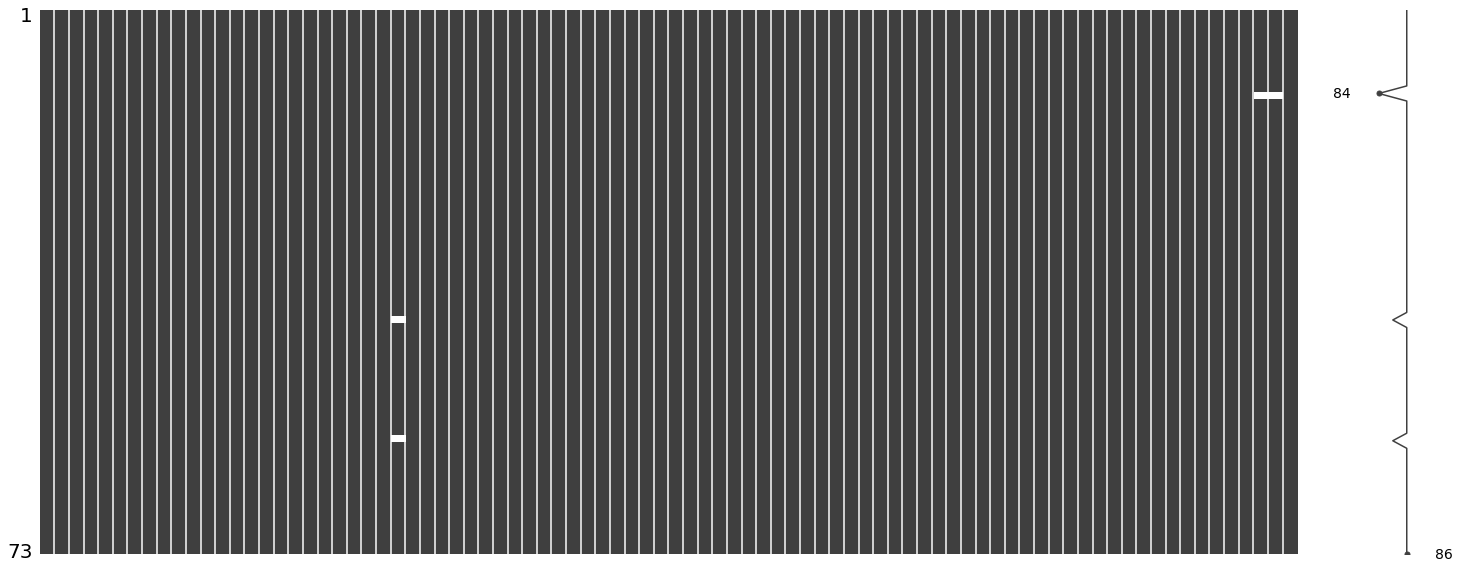

In [22]:
msno.matrix(neigh)

# Save data

In [23]:
if SAVE_INTERIM:
    neigh.to_file(DIR_DATA / "interim/neighbourhoods_geo.json", driver="GeoJSON")
    neigh.drop(["geometry"], axis=1, inplace=True)
    neigh.to_csv(DIR_DATA / "interim/neighbourhoods.csv")

In [24]:
neigh

,N_district,N_neighbourhood,Distance_Center,POI_Daily_Food,POI_Daily_Others,POI_House_Equipment,POI_Clothing,POI_Culture,POI_Vehicles,POI_State_Agents,...,Nationality_Bangladesh,Nationality_Georgia,Nationality_Armenia,Nationality_Japan,Nationality_Nepal,Nationality_Oceania,Rent_Number_Flats,Rent_Price_Meter_Flats,Rent_Price_Total_Flats,Rent_Area_Flats
Tag,,,,,,,,,,,,,,,,,,,,,
01_01,01,01,0.891972,484,81,84,191,133,1,10,...,0.059246,0.001292,0.000917,0.000834,0.003063,0.000688,2003,13.915648,748.579486,59.218221
01_02,01,02,0.878833,106,74,46,443,54,1,3,...,0.006158,0.001786,0.000554,0.002463,0.000862,0.002094,808,14.191885,973.270161,77.628242
01_03,01,03,1.972127,101,20,8,25,17,0,10,...,0.000993,0.000596,0.000530,0.000728,0.001391,0.002119,857,19.844592,745.814714,40.104113
01_04,01,04,1.116794,210,56,52,284,22,1,17,...,0.001963,0.002007,0.000349,0.003010,0.000262,0.002050,1309,15.713611,916.652697,66.137255
02_05,02,05,1.499156,136,53,72,58,34,18,14,...,0.001092,0.000999,0.000312,0.000780,0.000718,0.000281,1054,13.114796,900.418197,74.004119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10_69,10,69,4.114323,36,22,7,74,11,0,5,...,0.000000,0.000656,0.000656,0.000656,0.000000,0.000365,394,16.031175,1092.062970,94.374172
10_70,10,70,4.875155,106,24,11,12,7,1,5,...,0.001048,0.002577,0.001179,0.000087,0.002665,0.000044,354,10.031687,613.031243,62.358974
10_71,10,71,3.817310,34,24,13,8,11,5,6,...,0.000097,0.001743,0.001017,0.000048,0.000533,0.000048,427,12.935797,932.015902,72.045213


# Watermark

In [25]:
%load_ext watermark

In [26]:
# NBVAL_IGNORE_OUTPUT
%watermark -a "Ernesto Gregori" -u -d -t -v -m -g -wb

Author: Ernesto Gregori

Last updated: 2021-04-14 16:20:36

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.8.0-48-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: 0d4a5de134073a6916c8b74a514d792c1ff3474c

Git branch: master

Watermark: 2.2.0



In [27]:
# NBVAL_IGNORE_OUTPUT
%watermark -iv

lxml     : 4.6.3
numpy    : 1.20.2
missingno: 0.4.2
geopandas: 0.9.0
pandas   : 1.2.3

